In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from gensim.models.fasttext import load_facebook_vectors
from gensim.models.keyedvectors import KeyedVectors

### Functions

In [2]:
def similarities(
    M: np.ndarray, idx_target: list, idx_attr: list, use_norm=True
) -> np.ndarray:
    """use_norm: cosine distance
    """
    M_t = M[idx_target, :] # matriz de target words
    M_a = M[idx_attr, :] # matriz de attr words
    res = M_t @ M_a.T # rows: target words // cols: dot with each attr
    if use_norm:
        normas_t = np.linalg.norm(M_t, axis=1)
        normas_a = np.linalg.norm(M_a, axis=1)
        denominadores = np.outer(normas_t, normas_a)
        res = res / denominadores
    return res


def gensim2biasdf(model: KeyedVectors, words_a: list, words_b: list) -> pd.DataFrame:
    """
    """
    # DF with vocab and freq rank
    df = pd.DataFrame(model.key_to_index.items(), columns=["word", "idx"])
    df["freq"] = df["word"].apply(lambda x: model.get_vecattr(x, "count"))
    df.sort_values(by="freq", ascending=False, inplace=True)
    # exclude attribute words
    idx_a = df.query("word in @words_a")["idx"].values
    idx_b = df.query("word in @words_b")["idx"].values
    idx_target = np.setdiff1d(df["idx"].values, np.union1d(idx_a, idx_b))
    df = df.query("idx in @idx_target").copy()
    # compute similarities with attributes
    similarities_a = similarities(model.vectors, idx_target, idx_a)
    similarities_b = similarities(model.vectors, idx_target, idx_b)
    # compute bias
    biases = np.mean(similarities_a, axis=1) - np.mean(similarities_b, axis=1)
    df["bias"] = biases    
    return df

### Parameters

In [3]:
WORDS_A = [
    "mujer", "niña", "hermana", "ella", "hija",
    "Mujer", "Niña", "Hermana", "Ella", "Hija"
    # "ella", "ellas", "Ella", "Ellas"
    ]
WORDS_B = [
    "hombre", "niño", "hermano", "él", "hijo",
    "Hombre", "Niño", "Hermano", "Él", "Hijo"
    # "él", "ellos", "Él", "Ellos"
]
# female, woman, girl, sister, she, her, hers, daughter (LL2020, CBN2017)

# WORDS_A = ["la", "las", "ella", "ellas"]
# WORDS_B = ["el", "los", "él", "ellos"]


MODEL_PATH = "./models/cc.es.300.bin"

### Load model

In [4]:
%%time
model = load_facebook_vectors(MODEL_PATH)

CPU times: user 1min 15s, sys: 6.94 s, total: 1min 21s
Wall time: 2min 9s


### Analyze

In [5]:
# freq. ranking of each word
vocab = model.key_to_index
print([(w, vocab[w]) for w in WORDS_A])
print([(w, vocab[w]) for w in WORDS_B])

[('mujer', 432), ('niña', 1898), ('hermana', 2083), ('ella', 227), ('hija', 1073), ('Mujer', 3600), ('Niña', 16353), ('Hermana', 33110), ('Ella', 2125), ('Hija', 19212)]
[('hombre', 367), ('niño', 889), ('hermano', 1229), ('él', 206), ('hijo', 533), ('Hombre', 3906), ('Niño', 4916), ('Hermano', 12234), ('Él', 1862), ('Hijo', 4460)]


In [6]:
%%time
df_bias = gensim2biasdf(model, WORDS_A, WORDS_B)

CPU times: user 13.3 s, sys: 2.37 s, total: 15.7 s
Wall time: 10.5 s


In [7]:
df_bias.shape

(1999980, 4)

In [8]:
df_bias["last_char"] = df_bias["word"].str[-1]

In [9]:
# words masc y fem
# Fuente: https://www.ejemplos.co/sustantivos-masculinos-y-femeninos/#ixzz7YkhgpbhX
# NOTE saco palabras que pueden tomar forma masc o fem
words_masc = [
    "adorno", "almíbar", "amanecer", "amor", "apunte", "árbol", 
    "automóvil", "bolígrafo", "café", "calor", "camaleón", "camino", 
    "carpincho", "carruaje", "celular", "color", "corcel", "coro", 
    "cuaderno", "dolor", "domingo", "hormiguero", "libro", "local", 
    "mate", "miércoles", "monitor", "norte", "orégano", "pan", "pañuelo", 
    "parto", "perejil", "pincel", "púlpito", "roedor", "sendero", 
    "sol", "sonajero", "sostén", "sur", "taladro", "té", "teclado", "zurco"
]
    # "corredor", "león", "pollo", "zorro", "andador"
words_masc += [w.capitalize() for w in words_masc]
words_fem = [
    "acción", "barbarie", "canción", "carpa", "cocina", "costumbre", "crisis", 
    "edad", "epidermis", "esfinge", "eternidad", "fiesta", "hiena", "liebre", 
    "luna", "mansión", "medalla", "mesa", "metamorfosis", "muchedumbre", 
    "nariz", "nutria", "parálisis", "pasión", "perdiz", "pieza", "pintura", 
    "piñata", "planta",  "raíz", "serie", "sintaxis", "superficie", "tabla", 
    "tarjeta", "taza", "televisión", "universidad", "voz"
    # "actriz", "hija", "duquesa", "leona", "nuera", "prima", "princesa", "reina"
    # "suegra","vaca", "voz", "yegua", 
]
words_fem += [w.capitalize() for w in words_fem]

In [10]:
# sustantivos femeninos que terminan en o
words_fem_o = [
    "moto", "foto", "mano", "radio", "líbido", "libido",
]
words_fem_o += [w.capitalize() for w in words_fem_o]

# sustantivos masculinos que terminan en a
words_masc_a = [
    "día", "clima", "problema", "lema", "telegrama", "programa", "mapa", 
    "sistema", "poema", "drama", "tema", "dilema", "idioma", "planeta", 
    "fantasma", "diagrama", "crucigrama", "diploma", "panorama", "síntoma", 
    "trauma", "carisma", "aroma", "esquema", "enigma", "bocata", "pesticida", 
    "dogma", "plasma", "prisma", 
    # sofá
]
words_masc_a += [w.capitalize() for w in words_masc_a]

In [11]:
df_bias.loc[df_bias["word"].isin(words_fem + words_fem_o), "gender"] = "F"
df_bias.loc[df_bias["word"].isin(words_masc + words_masc_a), "gender"] = "M"

In [12]:
df_tmp = df_bias.query("gender in ['M','F']").copy()

# sns.displot(data=df_tmp, x="bias", hue="last_char", kde=True)
# plt.show()

In [13]:
df_tmp["last_char_grouped"] = np.where(
    df_tmp["last_char"].isin(["a","o"]), df_tmp["last_char"], "1other"
)

In [14]:
pd.crosstab(df_tmp["last_char_grouped"], df_tmp["gender"])


gender,F,M
last_char_grouped,,
1other,48,54
a,30,60
o,12,35


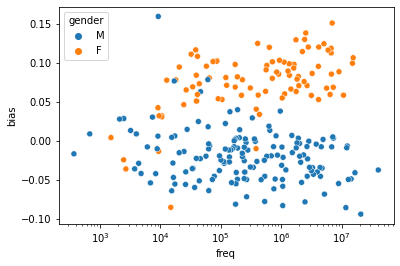

In [15]:
# scatter plot between freq and bias
sns.scatterplot(data=df_tmp, x="freq", y="bias", hue="gender")
plt.xscale("log")

In [16]:
# # scatter plot between freq and bias
# sns.scatterplot(data=df_tmp, x="freq", y="bias", hue="last_char_grouped")
# plt.xscale("log")

In [17]:
mod = smf.ols(formula="bias ~ np.log(freq) + gender + last_char_grouped", data=df_tmp)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   bias   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     99.34
Date:                Mon, 11 Jul 2022   Prob (F-statistic):           2.74e-49
Time:                        15:09:47   Log-Likelihood:                 458.89
No. Observations:                 239   AIC:                            -907.8
Df Residuals:                     234   BIC:                            -890.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [18]:
df_tmp.query("gender == 'M'").groupby("last_char_grouped")[["bias"]].describe()

bias                                                    \
                  count      mean       std       min       25%       50%   
last_char_grouped                                                           
1other             54.0 -0.020588  0.026448 -0.078439 -0.044312 -0.011349   
a                  60.0 -0.023841  0.031967 -0.094093 -0.042505 -0.023580   
o                  35.0 -0.011125  0.045062 -0.081369 -0.039699 -0.022683   

                                       
                        75%       max  
last_char_grouped                      
1other            -0.003097  0.039583  
a                 -0.003304  0.076413  
o                  0.002984  0.159038

In [19]:
df_tmp.query("gender == 'F'").groupby("last_char_grouped")[["bias"]].describe()

bias                                                    \
                  count      mean       std       min       25%       50%   
last_char_grouped                                                           
1other             48.0  0.073419  0.040456 -0.085438  0.058831  0.079828   
a                  30.0  0.088237  0.030865 -0.013648  0.073534  0.095721   
o                  12.0  0.052650  0.038533 -0.024578  0.047367  0.058067   

                                       
                        75%       max  
last_char_grouped                      
1other             0.096285  0.150554  
a                  0.111219  0.129617  
o                  0.072155  0.115924

In [20]:
df_tmp.query("gender == 'F' & last_char == 'o'")

,word,idx,freq,bias,last_char,gender,last_char_grouped
514,mano,514,10795364,0.058223,o,F,o
974,foto,974,5994534,0.115924,o,F,o
1450,radio,1450,4170653,0.052549,o,F,o
1923,Radio,1923,3165679,0.057912,o,F,o
3037,Foto,3037,1965957,0.070397,o,F,o
5553,moto,5553,1041190,0.054613,o,F,o
12657,Moto,12657,384475,-0.010246,o,F,o
15041,Mano,15041,308473,0.067471,o,F,o
47066,libido,47066,64491,0.080281,o,F,o
135868,líbido,135868,12754,0.077432,o,F,o


In [21]:
df_tmp.query("gender == 'M' & last_char == 'o'")

,word,idx,freq,bias,last_char,gender,last_char_grouped
315,libro,315,16700136,-0.041073,o,M,o
637,camino,637,8946909,-0.054956,o,M,o
1362,domingo,1362,4408927,-0.034419,o,M,o
2250,Domingo,2250,2701971,-0.045569,o,M,o
2854,Libro,2854,2109032,-0.027685,o,M,o
4894,Camino,4894,1198532,-0.037471,o,M,o
5440,teclado,5440,1064648,-0.058426,o,M,o
5921,parto,5921,967585,0.037783,o,M,o
7406,coro,7406,749075,-0.007760,o,M,o
10885,sendero,10885,466155,-0.050058,o,M,o


In [22]:
# df_bias.query("idx <= 1e5 & last_char == 'a'")["bias"].hist(bins=30)
# plt.axvline(x=0, c="black")

In [23]:
# df_bias.query("idx <= 1e5 & last_char == 'o'")["bias"].hist(bins=30)
# plt.axvline(x=0, c="black")